In [65]:
import pandas as pd
import re

In [66]:
dataset_top_5 = pd.read_csv("skipped_wiki-large_top_10.txt")
dataset_top_10 = pd.read_csv("skipped_wiki-large_top_50.txt")
dataset_top_100 = pd.read_csv("skipped_wiki-large_top_100.txt")
dataset_top_5.info()

datasetName = "Wiki-large"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1101039 entries, 0 to 1101038
Data columns (total 4 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   QueryId       1101039 non-null  int64  
 1   Algorithm     1101039 non-null  object 
 2   DocIdSkipped  1101039 non-null  int64  
 3   ProcessTime   1101039 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 33.6+ MB


In [67]:
f = open("posting_length_ms-marco.txt","r")
lines = f.readlines()
sizes = dict()
sizes["MAX_SCORE"] = dict()
sizes["WAND"] = dict()
sizes["LAZY_BM"] = dict()
avgSizes = dict()
avgSizes["MAX_SCORE"] = dict()
avgSizes["WAND"] = dict()
avgSizes["LAZY_BM"] = dict()
for line in lines:
    line = line.replace("\n", "")
    lineData = line.split(",")
    querySizes = []
    for i in range(2, len(lineData)):
        if len(lineData[i]) > 0:
            querySizes.append(int(lineData[i]))
    sizes[lineData[1]][lineData[0]] = querySizes
    if len(querySizes) > 0:
        avgSizes[lineData[1]][int(lineData[0])] = int(sum(querySizes) / len(querySizes))
    else:
        avgSizes[lineData[1]][int(lineData[0])] = 0

In [68]:
algorithms = []
queryIds = []
avgSizeList = []
processTime = []
for alg in avgSizes:
    for queryId in avgSizes[alg]:
        algorithms.append(alg)
        queryIds.append(queryId)
        avgSizeList.append(avgSizes[alg][queryId]) 

df0 = pd.DataFrame(
    {'Algorithm': algorithms,
     'QueryId': queryIds,
     'AvgListSize': avgSizeList
    })

<Axes: title={'center': 'DocIdSkipped'}, xlabel='Algorithm'>

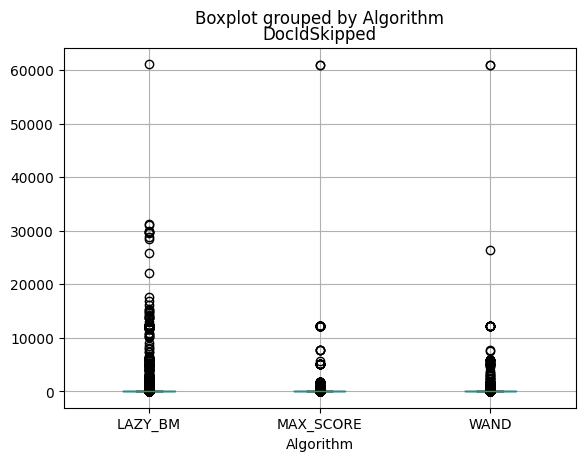

In [69]:
dataset_top_5.boxplot(column=['DocIdSkipped'], by='Algorithm')

(0.0, 60.0)

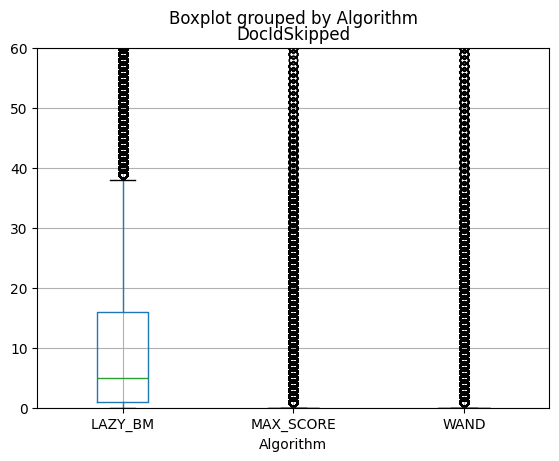

In [70]:
boxplot = dataset_top_5.boxplot(column=['DocIdSkipped'], by='Algorithm')
boxplot.set_ylim([0, 60])

(0.0, 60.0)

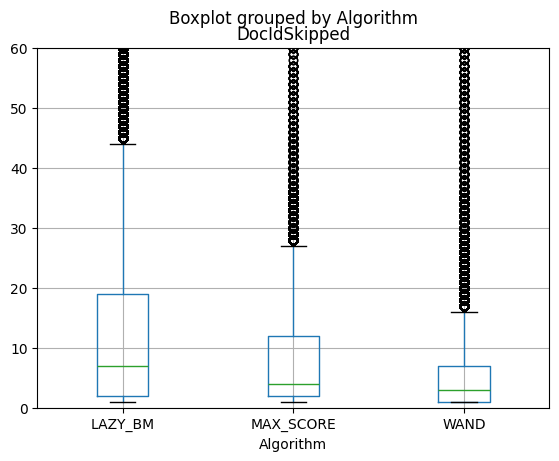

In [71]:
dataset_top_5_without_0 = dataset_top_5[dataset_top_5.DocIdSkipped != 0] 
boxplot = dataset_top_5_without_0.boxplot(column=['DocIdSkipped'], by='Algorithm')
boxplot.set_ylim([0, 60])

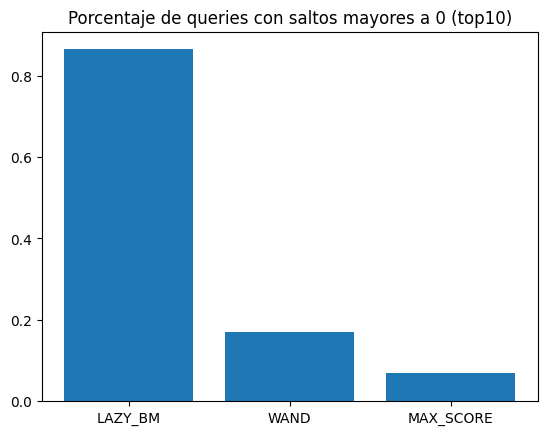

In [72]:
import matplotlib.pyplot as plt

def plot0(dataset0, topK0):
    dataset0_only_0 = dataset0[dataset0.DocIdSkipped == 0] 
    group_0 = dataset0_only_0.groupby(['Algorithm']).size()
    group_total = dataset0.groupby(['Algorithm']).size()

    porcents = dict()
    for algorithm in ["LAZY_BM", "WAND", "MAX_SCORE"]:
        porcents[algorithm] = 1 - (group_0[algorithm] / group_total[algorithm])

    plt.bar(*zip(*porcents.items()))
    plt.title(f"Porcentaje de queries con saltos mayores a 0 (top{topK0})")
    plt.show()

plot0(dataset_top_5, 10)

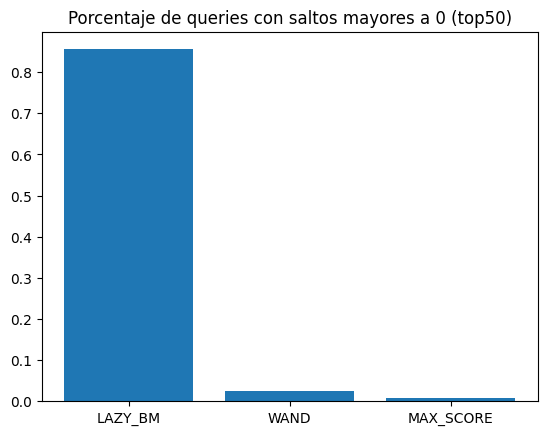

In [73]:
plot0(dataset_top_10, 50)

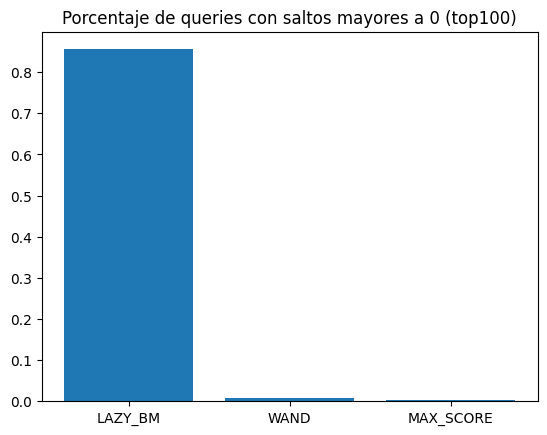

In [74]:
plot0(dataset_top_100, 100)

Text(0.5, 1.0, 'Proporción de queries que tuvieron al menos un salto de doc-id por algoritmo y top-k (Wiki-large)')

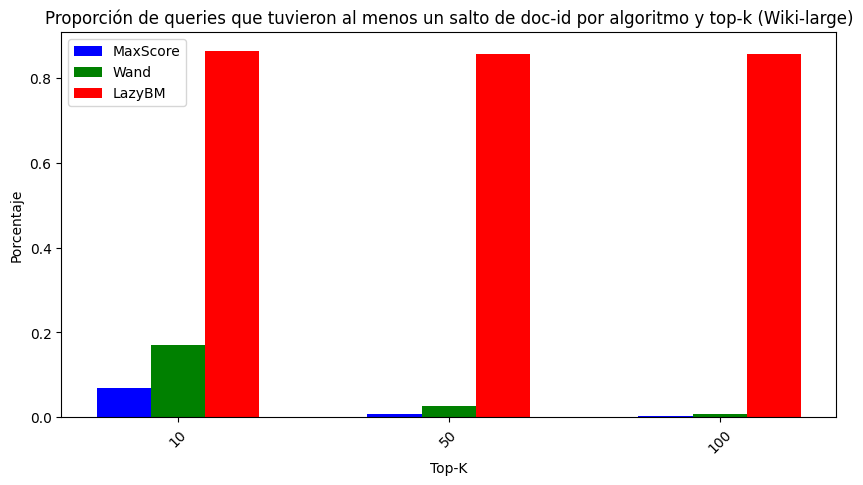

In [75]:
import numpy as np

porcents = dict()
topKList = [10, 50, 100]
topKIdx = 0
for ds in [dataset_top_5, dataset_top_10, dataset_top_100]:
    porcents[topKList[topKIdx]] = dict()
    for idx, group in ds.groupby("Algorithm"):
        dataset0_only_0 = group[group.DocIdSkipped == 0].shape[0]
        #group_0 = dataset0_only_0.groupby([idx]).size()
        group_total = group.shape[0]
        porcents[topKList[topKIdx]][idx] = 1 - (dataset0_only_0 / group_total)
    topKIdx += 1
df = pd.DataFrame.from_dict(porcents, orient='index')

#df = df.T

x = np.arange(3) 
fig, ax = plt.subplots(figsize=(10, 5))
width = 0.2

# Graficar cada serie con un desplazamiento en el eje X
bars1 = ax.bar(x - width, df["MAX_SCORE"], width=width, label='MaxScore', color='blue')
bars2 = ax.bar(x, df["WAND"], width=width, label='Wand', color='green')
bars3 = ax.bar(x + width, df["LAZY_BM"], width=width, label='LazyBM', color='red')

# Configurar el eje X con las etiquetas de los rangos
ax.set_xticks(x)


plt.legend()

algorithms = ["10", "50", "100"]
# Agregar etiquetas
ax.set_xlabel("Top-K")
ax.set_ylabel("Porcentaje")
ax.set_xticklabels(algorithms, rotation=45)
ax.set_title(f"Proporción de queries que tuvieron al menos un salto de doc-id por algoritmo y top-k ({datasetName})")

In [76]:
dataset_top_5_merged = pd.merge(
    left=dataset_top_5,
    right=df0,
    how='left',
    left_on=['Algorithm', 'QueryId'],
    right_on=['Algorithm', 'QueryId'],
)
dataset_top_5_merged

,QueryId,Algorithm,DocIdSkipped,ProcessTime,AvgListSize
0,1185869,MAX_SCORE,0,0.001001,3
1,1185869,WAND,0,0.001000,3
2,1185869,LAZY_BM,75,0.001001,3
3,1185868,MAX_SCORE,0,0.001001,20
4,1185868,WAND,0,0.001001,20
...,...,...,...,...,...
1101034,706678,WAND,0,0.000000,12
1101035,706678,LAZY_BM,2,0.000000,12
1101036,405466,MAX_SCORE,0,0.001000,63
1101037,405466,WAND,2,0.000000,63


In [77]:
dataset_top_10_merged = pd.merge(
    left=dataset_top_10,
    right=df0,
    how='left',
    left_on=['Algorithm', 'QueryId'],
    right_on=['Algorithm', 'QueryId'],
)
dataset_top_10_merged

,QueryId,Algorithm,DocIdSkipped,ProcessTime,AvgListSize
0,1185869,MAX_SCORE,0,0.001001,3
1,1185869,WAND,0,0.001001,3
2,1185869,LAZY_BM,23,0.001001,3
3,1185868,MAX_SCORE,0,0.001001,20
4,1185868,WAND,0,0.000000,20
...,...,...,...,...,...
1101034,706678,WAND,0,0.000000,12
1101035,706678,LAZY_BM,2,0.000000,12
1101036,405466,MAX_SCORE,0,0.000000,63
1101037,405466,WAND,0,0.000000,63


In [78]:
dataset_top_100_merged = pd.merge(
    left=dataset_top_100,
    right=df0,
    how='left',
    left_on=['Algorithm', 'QueryId'],
    right_on=['Algorithm', 'QueryId'],
)
dataset_top_100_merged

,QueryId,Algorithm,DocIdSkipped,ProcessTime,AvgListSize
0,1185869,MAX_SCORE,0,0.001001,3
1,1185869,WAND,0,0.001000,3
2,1185869,LAZY_BM,17,0.002002,3
3,1185868,MAX_SCORE,0,0.001002,20
4,1185868,WAND,0,0.001001,20
...,...,...,...,...,...
1101034,706678,WAND,0,0.000000,12
1101035,706678,LAZY_BM,2,0.000000,12
1101036,405466,MAX_SCORE,0,0.001001,63
1101037,405466,WAND,0,0.000000,63


In [79]:
print(dataset_top_5_merged.ProcessTime.agg("mean"))
print(dataset_top_10_merged.ProcessTime.agg("mean"))
print(dataset_top_100_merged.ProcessTime.agg("mean"))

0.0003774790057463632
0.0004934736170070792
0.0006112099459531693


In [80]:
processTimeAvg = dict()

for idx, group in dataset_top_5_merged.groupby("Algorithm"):
    if idx not in processTimeAvg:
        processTimeAvg[idx] = 0
    processTimeAvg[idx] += group.ProcessTime.agg("mean")

for idx, group in dataset_top_10_merged.groupby("Algorithm"):
    if idx not in processTimeAvg:
        processTimeAvg[idx] = 0
    processTimeAvg[idx] += group.ProcessTime.agg("mean")

for idx, group in dataset_top_100_merged.groupby("Algorithm"):
    if idx not in processTimeAvg:
        processTimeAvg[idx] = 0
    processTimeAvg[idx] += group.ProcessTime.agg("mean")

for key in processTimeAvg:
    processTimeAvg[key] /= 3

processTimeAvg

{'LAZY_BM': np.float64(0.0004028861548111347),
 'MAX_SCORE': np.float64(0.0005454458796539276),
 'WAND': np.float64(0.0005338305342415499)}

Text(0, 0.5, 'Tiempo de procesamiento (segundos)')

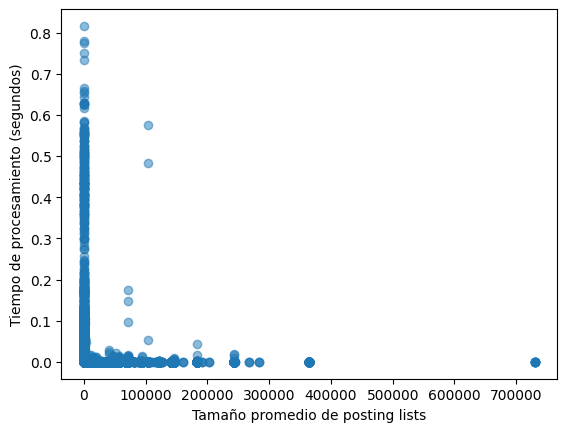

In [81]:
plt.scatter(dataset_top_5_merged["AvgListSize"], dataset_top_5_merged["ProcessTime"], alpha=0.5)
plt.xlabel("Tamaño promedio de posting lists")
plt.ylabel("Tiempo de procesamiento (segundos)")

In [82]:
def graphTimePerPostingListAvgSize(dataset0, topk0):
    # Definir los bins (límites de los rangos)
    bins = list(range(0, 800001, 100000))

    labels = [f"{bins[i]}-{bins[i+1]-1}" for i in range(len(bins)-1)]

    for idx, group in dataset0.groupby("Algorithm"):
        group['Range'] = pd.cut(group['AvgListSize'], bins=bins, labels=labels)

        boxplot = group.boxplot(column=['ProcessTime'], by='Range')
        plt.xticks(rotation=45, fontsize=8)
        plt.title(f"Tiempo de procesamiento agrupado por tamaño de posting lists ({idx} - topk={topk0}). ({datasetName})")
        plt.ylabel("Segundos")
    #boxplot.set_ylim([0, 60])

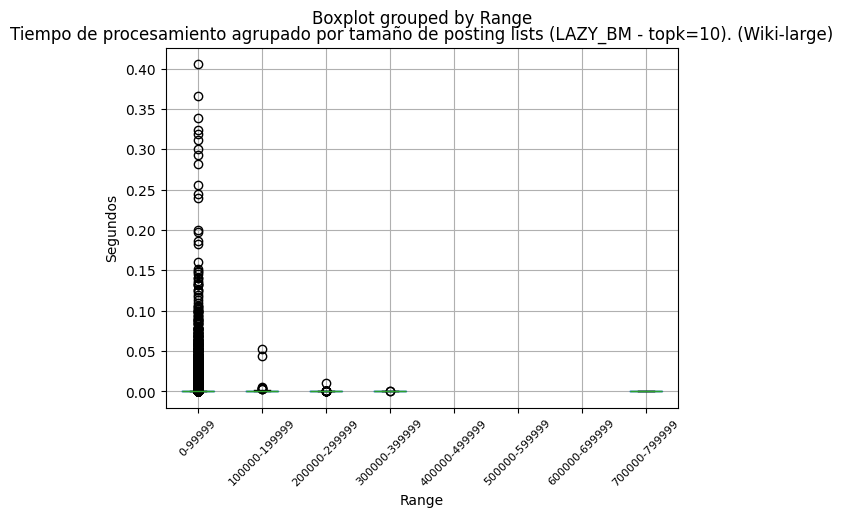

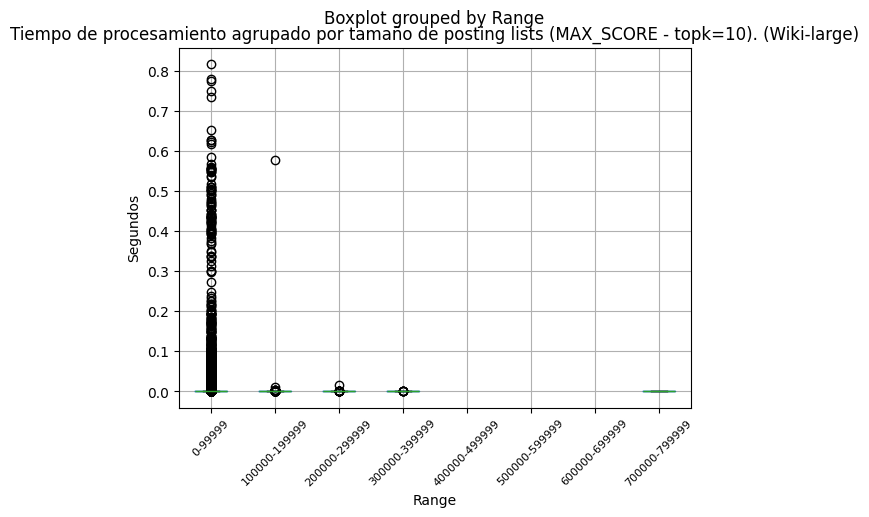

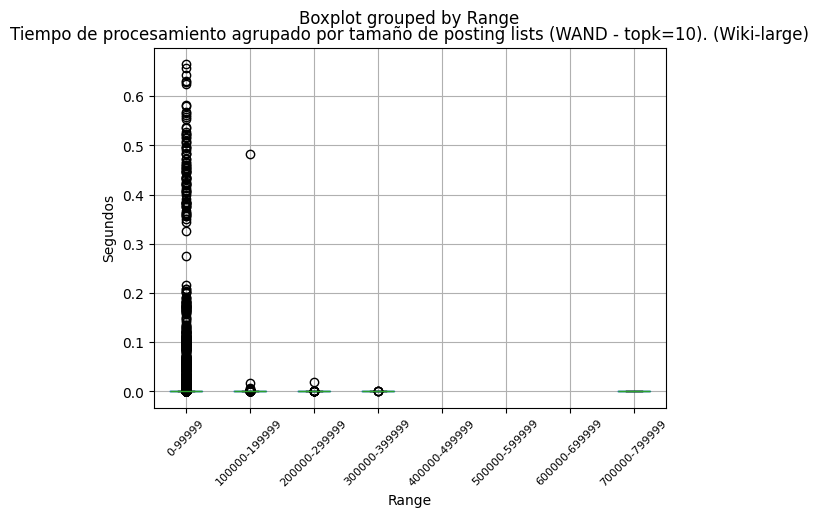

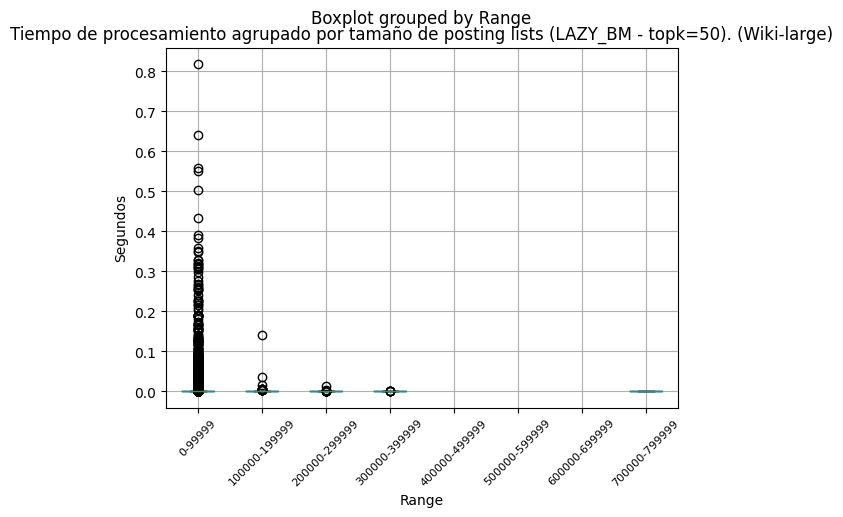

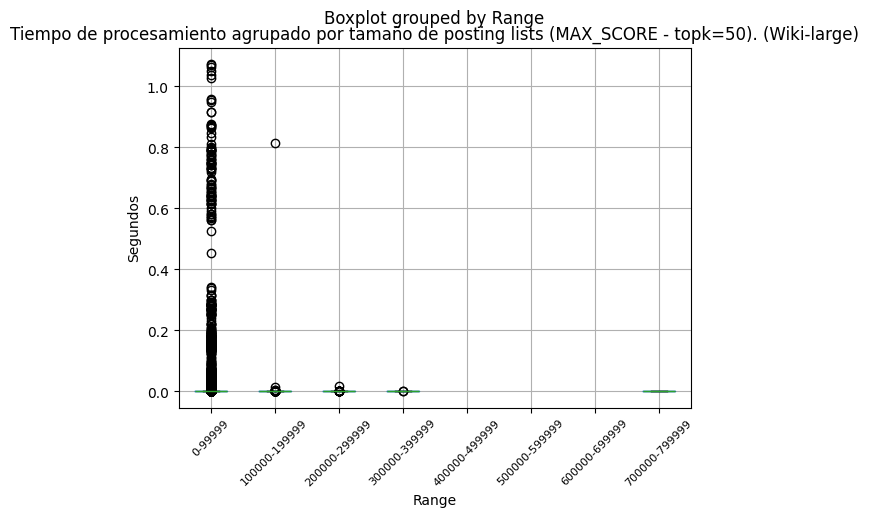

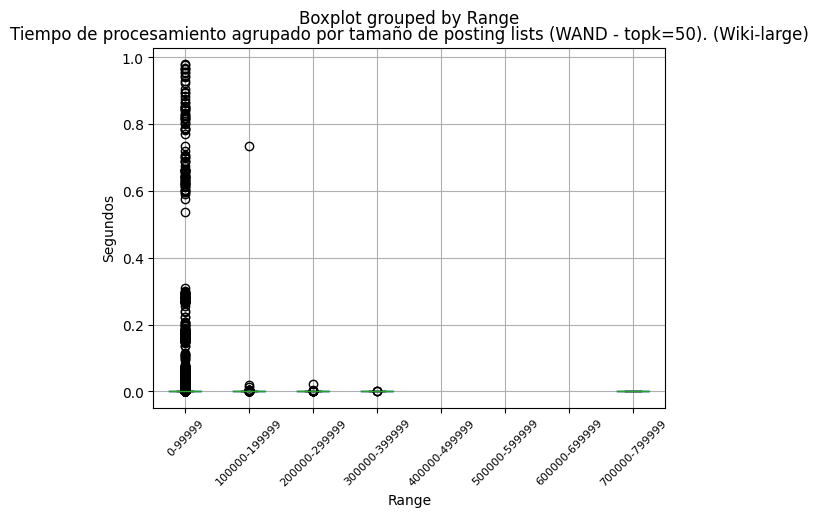

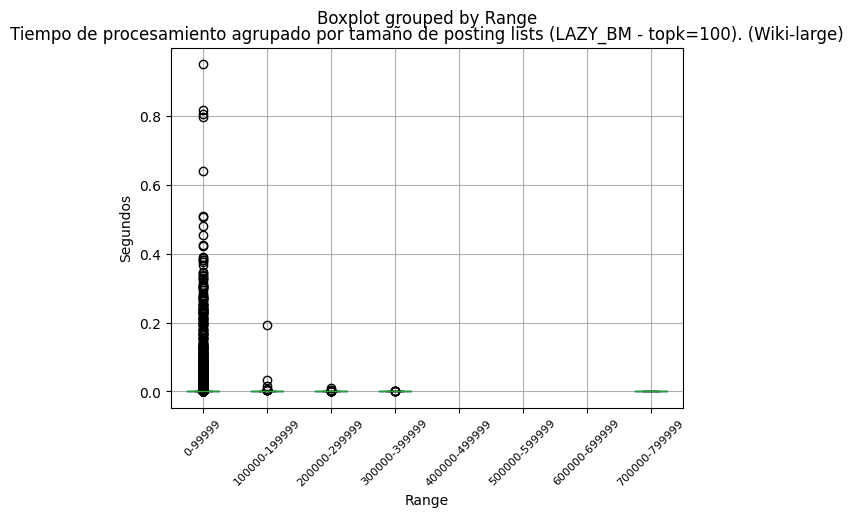

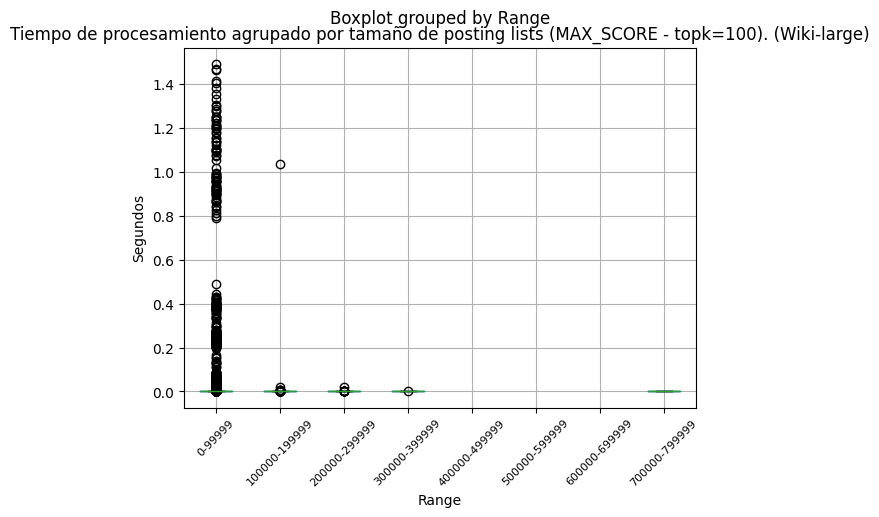

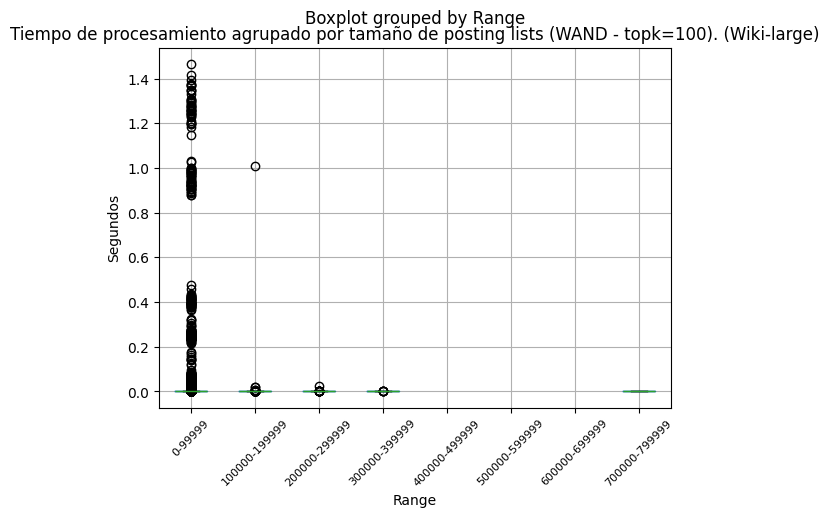

In [83]:
graphTimePerPostingListAvgSize(dataset_top_5_merged, 10)
graphTimePerPostingListAvgSize(dataset_top_10_merged, 50)
graphTimePerPostingListAvgSize(dataset_top_100_merged, 100)

In [84]:
dataset_top_5_merged.groupby(['Algorithm'])['DocIdSkipped'].mean()

Algorithm
LAZY_BM      21.243476
MAX_SCORE     3.020283
WAND          2.833366
Name: DocIdSkipped, dtype: float64

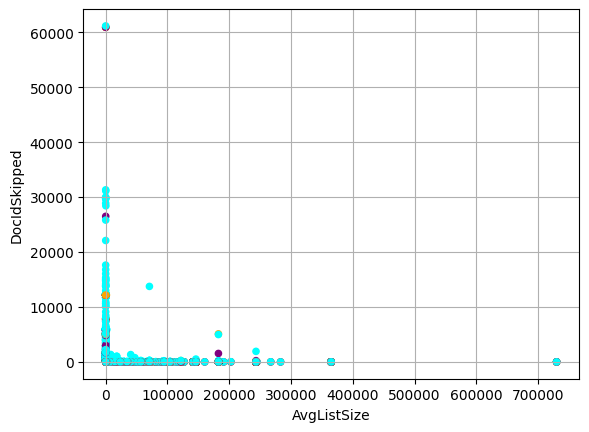

In [85]:
colors = {'MAX_SCORE': 'orange', 'WAND': 'purple', 'LAZY_BM': 'cyan'}
color_list = [colors[group] for group in dataset_top_5_merged['Algorithm']]

ax = dataset_top_5_merged.plot.scatter('AvgListSize',
                'DocIdSkipped',
                c=color_list,
                grid=True)
#dataset.reset_index().plot(kind='scatter', x='AvgListSize', y='Skipped')

In [86]:
labels = []
arrayTop5 = []
for Algorithm, df0 in dataset_top_5.groupby(['Algorithm'])['DocIdSkipped']:
    labels.append(Algorithm)
    arrayTop5.append(df0.values)

arrayTop10 = []
for Algorithm, df0 in dataset_top_10.groupby(['Algorithm'])['DocIdSkipped']:
    arrayTop10.append(df0.values)
arrayTop100 = []
for Algorithm, df0 in dataset_top_100.groupby(['Algorithm'])['DocIdSkipped']:
    arrayTop100.append(df0.values)

Text(20.847222222222214, 0.5, 'Doc ID Salteados')

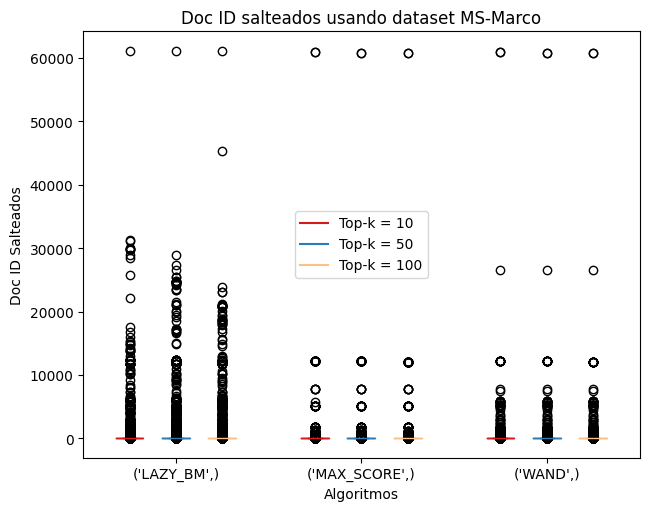

In [87]:
from matplotlib import pyplot as plt
import numpy as np

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure()

bp0 = plt.boxplot(arrayTop5, positions=np.array(range(len(arrayTop5)))*2.0-0.5, widths=0.3)
bp1 = plt.boxplot(arrayTop10, positions=np.array(range(len(arrayTop10)))*2.0, widths=0.3)
bp2 = plt.boxplot(arrayTop100, positions=np.array(range(len(arrayTop100)))*2.0+0.5, widths=0.3)
set_box_color(bp0, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bp1, '#2C7BB6')
set_box_color(bp2, '#fdc086')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='Top-k = 10')
plt.plot([], c='#2C7BB6', label='Top-k = 50')
plt.plot([], c='#fdc086', label='Top-k = 100')
plt.legend()

plt.xticks(range(0, len(labels) * 2, 2), labels)
#plt.ylim(0, 100)
plt.tight_layout()
plt.title("Doc ID salteados usando dataset MS-Marco")
plt.xlabel("Algoritmos")
plt.ylabel("Doc ID Salteados")

Text(47.097222222222214, 0.5, 'Doc ID Salteados')

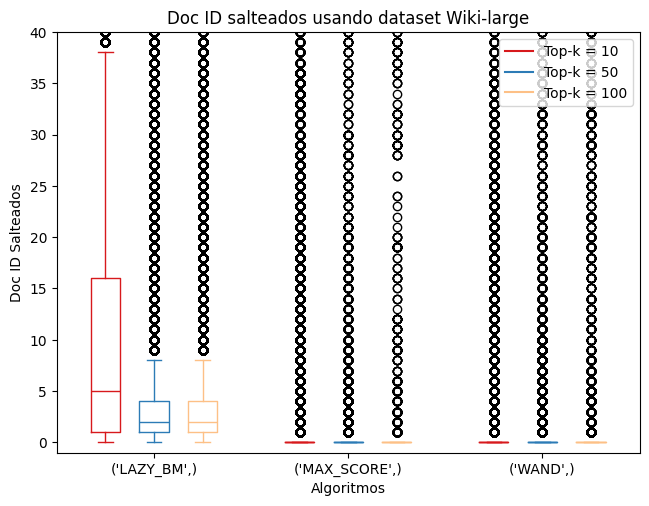

In [88]:
plt.figure()

bp0 = plt.boxplot(arrayTop5, positions=np.array(range(len(arrayTop5)))*2.0-0.5, widths=0.3)
bp1 = plt.boxplot(arrayTop10, positions=np.array(range(len(arrayTop10)))*2.0, widths=0.3)
bp2 = plt.boxplot(arrayTop100, positions=np.array(range(len(arrayTop100)))*2.0+0.5, widths=0.3)
set_box_color(bp0, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bp1, '#2C7BB6')
set_box_color(bp2, '#fdc086')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='Top-k = 10')
plt.plot([], c='#2C7BB6', label='Top-k = 50')
plt.plot([], c='#fdc086', label='Top-k = 100')
plt.legend(loc="upper right")
#plt.xticks(rotation=45)
plt.xticks(range(0, len(labels) * 2, 2), labels)
plt.ylim(-1, 40)
plt.tight_layout()
plt.title(f"Doc ID salteados usando dataset {datasetName}")
plt.xlabel("Algoritmos")
plt.ylabel("Doc ID Salteados")

Text(31.097222222222214, 0.5, 'Doc ID Salteados')

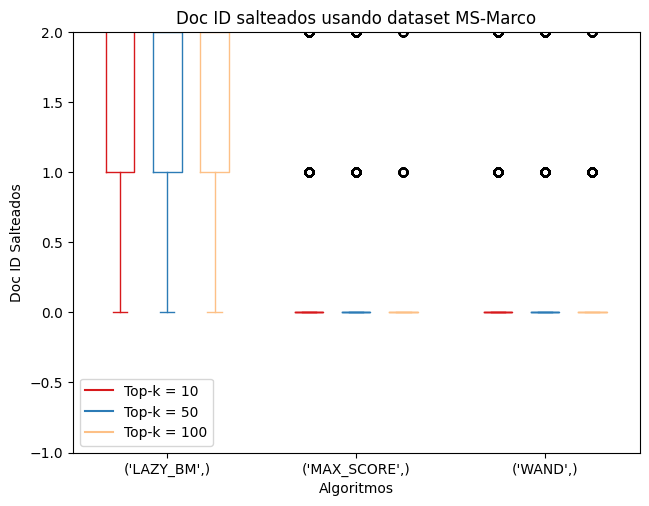

In [89]:
plt.figure()

bp0 = plt.boxplot(arrayTop5, positions=np.array(range(len(arrayTop5)))*2.0-0.5, widths=0.3)
bp1 = plt.boxplot(arrayTop10, positions=np.array(range(len(arrayTop10)))*2.0, widths=0.3)
bp2 = plt.boxplot(arrayTop100, positions=np.array(range(len(arrayTop100)))*2.0+0.5, widths=0.3)
set_box_color(bp0, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bp1, '#2C7BB6')
set_box_color(bp2, '#fdc086')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='Top-k = 10')
plt.plot([], c='#2C7BB6', label='Top-k = 50')
plt.plot([], c='#fdc086', label='Top-k = 100')
plt.legend()

plt.xticks(range(0, len(labels) * 2, 2), labels)
plt.ylim(-1, 2)
plt.tight_layout()
plt.title("Doc ID salteados usando dataset MS-Marco")
plt.xlabel("Algoritmos")
plt.ylabel("Doc ID Salteados")

In [90]:
def graphDocIdPerAlgorithm(arrayTop5_0, arrayTop10_0, arrayTop100_0, yMax):
    plt.figure()

    bp0 = plt.boxplot(arrayTop5_0, positions=np.array(range(len(arrayTop5_0)))*2.0-0.5, widths=0.3)
    bp1 = plt.boxplot(arrayTop10_0, positions=np.array(range(len(arrayTop10_0)))*2.0, widths=0.3)
    bp2 = plt.boxplot(arrayTop100_0, positions=np.array(range(len(arrayTop100_0)))*2.0+0.5, widths=0.3)
    set_box_color(bp0, '#D7191C') # colors are from http://colorbrewer2.org/
    set_box_color(bp1, '#2C7BB6')
    set_box_color(bp2, '#fdc086')

    # draw temporary red and blue lines and use them to create a legend
    plt.plot([], c='#D7191C', label='Top-k = 10')
    plt.plot([], c='#2C7BB6', label='Top-k = 50')
    plt.plot([], c='#fdc086', label='Top-k = 100')
    plt.legend()

    plt.xticks(range(0, len(labels) * 2, 2), labels)
    plt.ylim(-1, yMax)
    plt.tight_layout()
    plt.title(f"Doc ID salteados usando dataset {datasetName}, sin contar queries sin saltos")
    plt.xlabel("Algoritmos")
    plt.ylabel("Doc ID Salteados")

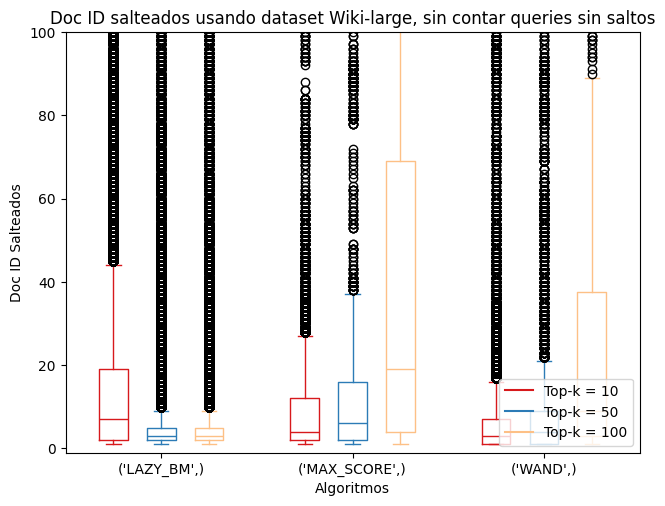

In [91]:
x0 = []
idx = 0
for xList in arrayTop5:
    x0.append([])
    for x in xList:
        if x != 0:
            x0[idx].append(x)
    idx += 1
x1 = []
idx = 0
for xList in arrayTop10:
    x1.append([])
    for x in xList:
        if x != 0:
            x1[idx].append(x)
    idx += 1
x2 = []
idx = 0
for xList in arrayTop100:
    x2.append([])
    for x in xList:
        if x != 0:
            x2[idx].append(x)
    idx += 1
graphDocIdPerAlgorithm(x0, x1, x2, 100)

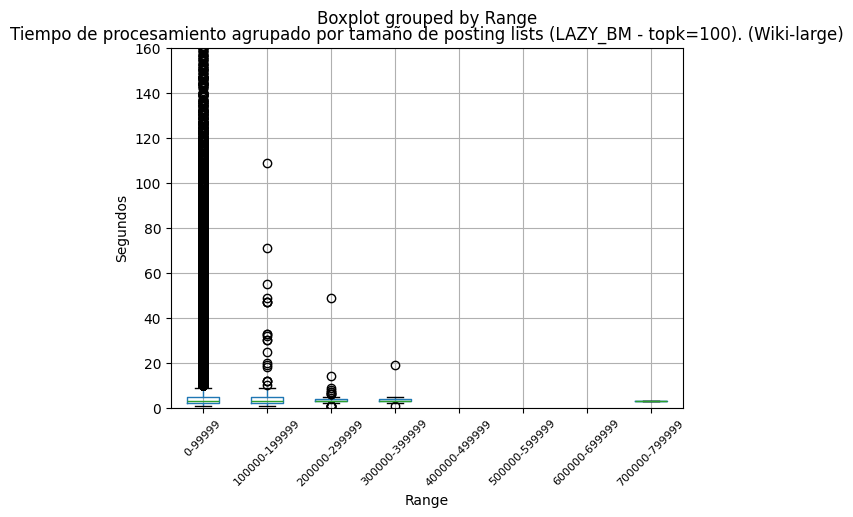

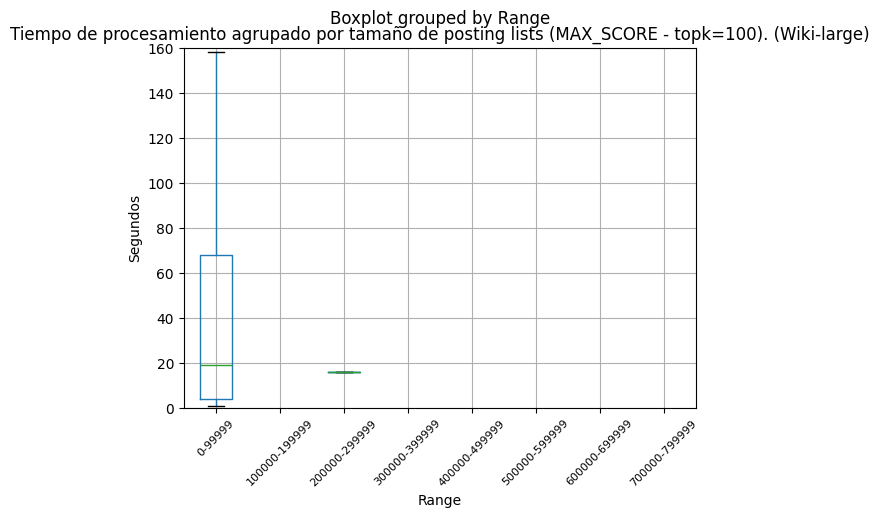

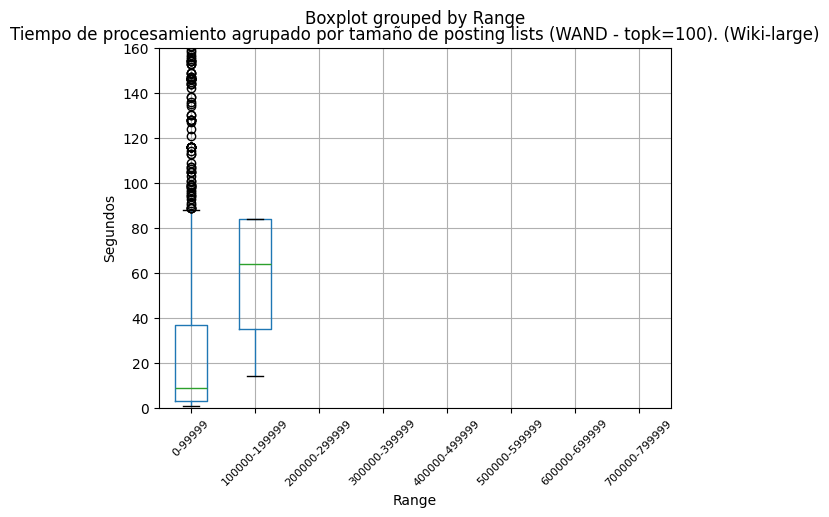

In [92]:
bins = list(range(0, 800001, 100000))

labels = [f"{bins[i]}-{bins[i+1]-1}" for i in range(len(bins)-1)]
for idx, group in dataset_top_100_merged.groupby("Algorithm"):
  
    group['Range'] = pd.cut(group['AvgListSize'], bins=bins, labels=labels)

    boxplot = group[group["DocIdSkipped"] != 0].boxplot(column=['DocIdSkipped'], by='Range')
    plt.xticks(rotation=45, fontsize=8)
    plt.title(f"Tiempo de procesamiento agrupado por tamaño de posting lists ({idx} - topk={100}). ({datasetName})")
    plt.ylabel("Segundos")
    plt.ylim(0, 160)